# 2.0 Exploring the Healthcare Provider Fraud Dataset

`Author: James Smith`

`Date of Creation: 21/03/2020`

`Programming for Big Data: Assignment 2`

`Overview: The purpose of this notebook is to explore the full dataset that was generated in the previous notebook.`

# Load Dataset

In [75]:
# For working with directories
import os
# Finds pathnames matching a specified pattern
import glob
# For data analysis and manipulation
import pandas as pd
# Linear algebra
import numpy as np
# To time processes
import time
# Quick EDA
from pandas_profiling import ProfileReport
# Working with dates
import datetime
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define working directory
path = os.getcwd()

# Define parent/project directory
project_directory = os.path.abspath(os.path.join(path, os.pardir))

# project_directory and data_folder are defined earlier
dataset_name = "1.0_joined_dataset"
processed_data_folder_path = os.path.join(project_directory,
                                          "data", "processed", 
                                          dataset_name)
# Load
df = pd.read_csv(processed_data_folder_path + ".csv")

C:\Users\User\Anaconda3\envs\research_project\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print("The table contains {} rows and {} columns".format(df.shape[0], df.shape[1]))
df.head()

The table contains 558211 rows and 54 columns


Unnamed: 0     BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0           0  BENE11001   CLM46614   2009-04-12  2009-04-18  PRV55912   
1           1  BENE16973  CLM565430   2009-09-06  2009-09-06  PRV55912   
2           2  BENE17521   CLM34721   2009-01-20  2009-02-01  PRV55912   
3           3  BENE21718   CLM72336   2009-10-17  2009-11-04  PRV55912   
4           4  BENE22934   CLM73394   2009-10-25  2009-10-29  PRV55912   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                      50          PHY365867          PHY327147   
2                   19000          PHY349293          PHY370861   
3                   17000          PHY334706          PHY334706   
4                   13000          PHY390614          PHY323689   

  OtherPhysician      ...       ChronicCond_Diabetes  \
0            NaN      ...                          1   
1            NaN      ...                          2   
2      PHY363291      ...                          2   
3            NaN      ...                          2   
4      PHY363291      ...                          1   

   ChronicCond_IschemicHeart ChronicCond_Osteoporasis  \
0                          1                        2   
1                          1                        2   
2                          1                        2   
3                          1                        1   
4                          1                        1   

  ChronicCond_rheumatoidarthritis ChronicCond_stroke IPAnnualReimbursementAmt  \
0                               1                  1                    36000   
1                               2                  2                    24000   
2                               2                  2                    19000   
3                               2                  2                    17000   
4                               1                  2                    27000   

  IPAnnualDeductibleAmt OPAnnualReimbursementAmt OPAnnualDeductibleAmt  \
0                  3204                       60                    70   
1                  2136                      450                   200   
2                  1068                      100                    20   
3                  1068                     1050                   540   
4                  2136                      450                   160   

  PotentialFraud  
0            Yes  
1            Yes  
2            Yes  
3            Yes  
4            Yes  

[5 rows x 54 columns]

# Quick Exploration Using Pandas Profiling

There was some issues using pip to install the latest version of this library. This library is using version 1.4.2, hence some of the newer features are unavailable.

In [6]:
t0 = time.time()
profile = ProfileReport(df)
print("Process took {} seconds".format(round(time.time() - t0, 2)))

profile

Process took 186.88 seconds


In [7]:
profile.to_file("Healthcare_Fraud_EDA_Pandas_Profile.html")

## Notes on Pandas Profile

- Missing values
    - 30% of rows have a missing value
    - Many claimant procedure columns are mostly missing values
    - DOD has 99.3% missing, because claimants are still alive
- Variable types
    - Some variables are unsupported or rejected - ClmDiagnosisCode_10
    - Variables with constant values - ClmProcedureCode_6
    - ProcedureCode are actually categorical - treated as numeric in table
    - Race is treated at numeric - but is actually categorical
    - Unnamed: 0 is old index - remove
- Feature Ideas
    - ClaimStartDt and ClaimEndDt - could be year-month, or day of week
    - DOB - could be **year** of year-month
    - DOD - flag for dead or not
    - Operating Physician & OtherPhysician - most are missing so could have Operaating Physician flag
- Fraud Flag
    - Not too much class imbalance - 61.9 / 38.1
 
 ## Actions on Pandas Profile
- **4: New Features**
    - Dead: Based on DOD, if data then 1 else 0
    - ClaimStartDt_year: Based on ClaimStartDt
    - ClaimStartDt_yearmonth: Based on ClaimStartDt
    - ClaimStartDt_dow: Day of week - Based on ClaimStartDt
    - ClaimEndDt_year: Based on ClaimEndDt
    - ClaimEndDt_yearmonth: Based on ClaimEndDt 
    - ClaimEndDt_dow: Day of week - Based on ClaimEndDt
    - ClaimLength: Number of days beween start and end
    - DOB_year: Based on DOB
    - OperatingPhysician_flag: Based on OperatingPhysician
    - OtherPhysician_flag: Based on OtherPhysician
- **5: Columns to remove**
    - ClmDiagnosisCode_10: Different variable types
    - ClmProcedureCode_6: Constant value
    - Unnamed: 0: Is old index
- **6: Columns to change**
    - Change ProcedureCode to categorical - mostly missing values though
    - Change Race to categorical
- **7: Correlation Matrix**
    - Do further remove columns that may be correlated together

# Initial Feature Engineering

There are several features that can be created from columns with missing values etc. Before we remove them we want to retain some information still.

In [55]:
# Dead: Indicator of whether claimant is dead or not - 0: 0.9926, 1: 0.0074
df["Dead"] = np.where(df["DOD"].isnull(), 0, 1)

# ClaimStartDt features
df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt']) 
df['ClaimStartDt_year'] = df['ClaimStartDt'].dt.year.astype(str)
df['ClaimStartDt_yearmonth'] = df['ClaimStartDt_year'].astype(str) + df['ClaimStartDt'].dt.month.astype(str)
df['ClaimStartDt_dow'] = df['ClaimStartDt'].dt.dayofweek.astype(str)

# ClaimStartDt features
df['ClaimEndDt'] = pd.to_datetime(df['ClaimEndDt']) 
df['ClaimEndDt_year'] = df['ClaimEndDt'].dt.year.astype(str)
df['ClaimEndDt_yearmonth'] = df['ClaimEndDt_year'].astype(str) + df['ClaimEndDt'].dt.month.astype(str)
df['ClaimEndDt_dow'] = df['ClaimEndDt'].dt.dayofweek.astype(str)

# ClaimLength
df['ClaimLength'] = (df['ClaimEndDt'] - df['ClaimStartDt']).dt.days

# DOB features
df['DOB'] = pd.to_datetime(df['DOB']) 
df['DOB_year'] = df['DOB'].dt.year.astype(str)

# Physician flag
df["OperatingPhysician_flag"] = np.where(df["OperatingPhysician"].isnull(), 0, 1)
df["OtherPhysician_flag"] = np.where(df["OtherPhysician"].isnull(), 0, 1)

In [56]:
df.head()

Unnamed: 0     BeneID    ClaimID ClaimStartDt ClaimEndDt  Provider  \
0           0  BENE11001   CLM46614   2009-04-12 2009-04-18  PRV55912   
1           1  BENE16973  CLM565430   2009-09-06 2009-09-06  PRV55912   
2           2  BENE17521   CLM34721   2009-01-20 2009-02-01  PRV55912   
3           3  BENE21718   CLM72336   2009-10-17 2009-11-04  PRV55912   
4           4  BENE22934   CLM73394   2009-10-25 2009-10-29  PRV55912   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                      50          PHY365867          PHY327147   
2                   19000          PHY349293          PHY370861   
3                   17000          PHY334706          PHY334706   
4                   13000          PHY390614          PHY323689   

  OtherPhysician         ...         ClaimStartDt_year  \
0            NaN         ...                      2009   
1            NaN         ...                      2009   
2      PHY363291         ...                      2009   
3            NaN         ...                      2009   
4      PHY363291         ...                      2009   

   ClaimStartDt_yearmonth ClaimStartDt_dow ClaimEndDt_year  \
0                   20094                6            2009   
1                   20099                6            2009   
2                   20091                1            2009   
3                  200910                5            2009   
4                  200910                6            2009   

  ClaimEndDt_yearmonth ClaimEndDt_dow ClaimLength DOB_year  \
0                20094              5           6     1943   
1                20099              6           0     1932   
2                20092              6          12     1913   
3               200911              2          18     1922   
4               200910              3           4     1930   

  OperatingPhysician_flag OtherPhysician_flag  
0                       0                   0  
1                       1                   0  
2                       1                   1  
3                       1                   0  
4                       1                   1  

[5 rows x 65 columns]

# Removing Columns

In [67]:
# From profile
cols_to_remove_profile = ["ClmDiagnosisCode_10", "ClmProcedureCode_6", "Unnamed: 0"]
df = df.drop(cols_to_remove_profile, axis = 1) 

## Columns with Missing Values

In [68]:
percent_missing = (df.isnull() | df.isna()).sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending = False, inplace=True)
missing_value_df.query("percent_missing > 0")

column_name  percent_missing
ClmProcedureCode_5        ClmProcedureCode_5        99.998388
ClmProcedureCode_4        ClmProcedureCode_4        99.978861
ClmProcedureCode_3        ClmProcedureCode_3        99.826410
DOD                                      DOD        99.259957
ClmProcedureCode_2        ClmProcedureCode_2        99.016501
ClmProcedureCode_1        ClmProcedureCode_1        95.824160
ClmDiagnosisCode_9        ClmDiagnosisCode_9        92.509105
ClmDiagnosisCode_8        ClmDiagnosisCode_8        90.425843
ClmDiagnosisCode_7        ClmDiagnosisCode_7        88.144805
ClmDiagnosisCode_6        ClmDiagnosisCode_6        84.881702
ClmDiagnosisCode_5        ClmDiagnosisCode_5        79.949517
OperatingPhysician        OperatingPhysician        79.497538
ClmAdmitDiagnosisCode  ClmAdmitDiagnosisCode        73.863109
ClmDiagnosisCode_4        ClmDiagnosisCode_4        70.524407
OtherPhysician                OtherPhysician        64.218548
ClmDiagnosisCode_3        ClmDiagnosisCode_3        56.458221
ClmDiagnosisCode_2        ClmDiagnosisCode_2        35.041588
ClmDiagnosisCode_1        ClmDiagnosisCode_1         1.872589
AttendingPhysician        AttendingPhysician         0.270149
DeductibleAmtPaid          DeductibleAmtPaid         0.161050

To make it earlier on ourselves with regards to imputing, we will remove all columns with missing values.

In [69]:
cols_to_remove_missing = list(missing_value_df.query("percent_missing > 0").index)
df = df.drop(cols_to_remove_missing, axis = 1) 

# Changing Columns Types

In [74]:
df["Race"] = df["Race"].astype(str)

# Correlation Matrix

This will be useful to gain more insight into our attributes and see if there is a need to further reduce the number of attributes that are highly correllated with each other.

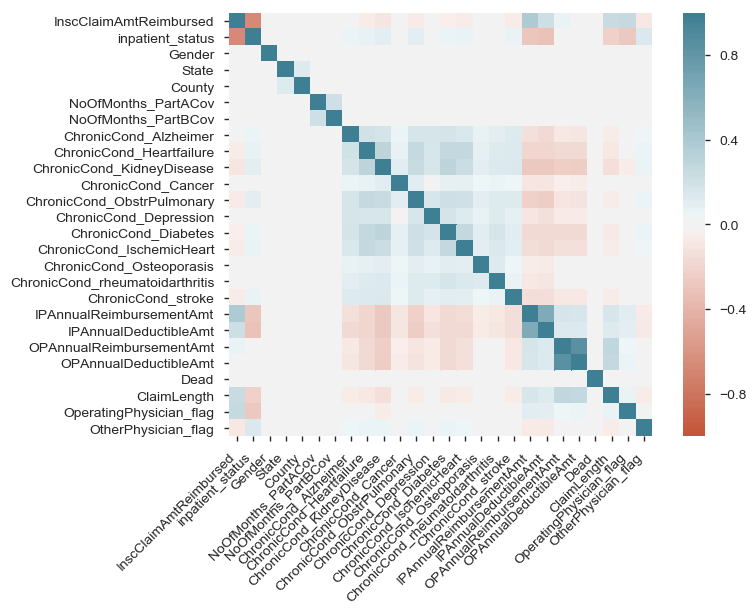

In [76]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From this plot it seems that we should only be concerned with the strong correlation between 
- InscClaimAmtReimbursed and inpatient_status
- OPAnnualReimbursementAmt and OPAnnualDeductibleAmt.

From looking at the `corr` defined above the correlation co-efficients are -0.665 and 0.837 respectively.

Based on this we shall remove `OPAnnualDeductibleAmt`

In [79]:
df = df.drop("OPAnnualDeductibleAmt", axis = 1) 

# Conclusion

We have explored the dataset and cleaned it. In the next notebook we will begin evaluating some models.

In [81]:
# project_directory and data_folder are defined earlier
dataset_name = "2.0_cleaned_dataset"
processed_data_folder_path = os.path.join(project_directory,
                                          "data", "processed", 
                                          dataset_name)

# Write as csv - takes time
df.to_csv(processed_data_folder_path + ".csv")